In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

# Load data

In [9]:
from load_ensembles import *
var='TS'

In [3]:
ensemble_coupled=load_ensembles.load_coupled_ensemble(var=var)

/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [4]:
basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.'+var+'.nc')

In [5]:
ref_tseries=basecase_lnd[var][60*12:,:,:].groupby('time.year').mean(dim='time')

# make grid

In [6]:
ds_grid = ensemble_coupled[0]

In [7]:
import make_multisimulation_dataset

In [10]:
var_array = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

In [11]:
var_array_pvals = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

In [99]:
season='Annual'#'Annual','DJF,'MAM','JJA','SON'
for i in np.arange(0,np.size(keys)):
    print(i)
    if season=='Annual':
        this_ensemble_tseries=ensemble_coupled[i][var][60*12:,:,:].groupby('time.year').mean(dim='time')
    else:
        seasonfilter=ensemble_coupled[i][var]['time.season']==season
        this_ensemble_tseries=ensemble_coupled[i][var][60*12:,:,:].where(seasonfilter).groupby('time.year').mean(dim='time')
    t, p = ttest_ind(this_ensemble_tseries, ref_tseries, equal_var=False)
    diff = this_ensemble_tseries.mean(dim='year')-ref_tseries.mean(dim='year')
    
    var_array[:,:,i]=diff
    var_array_pvals[:,:,i]=p

0


TypeError: ttest_ind() got an unexpected keyword argument 'alternative'

3.8508117
0.000170862109917824


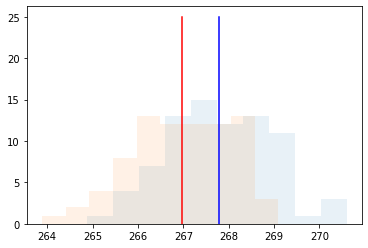

In [150]:
t, p = ttest_ind(this_ensemble_tseries, ref_tseries, equal_var=False)

ilat=80
ilon=40
plt.hist(this_ensemble_tseries[:, ilat,ilon], alpha=0.1)
plt.plot([np.nanmean(this_ensemble_tseries[:, ilat,ilon]),
          np.nanmean(this_ensemble_tseries[:, ilat,ilon])],
         [0,25],'-b')
plt.hist(ref_tseries[:, ilat,ilon], alpha=0.1)
plt.plot([np.nanmean(ref_tseries[:, ilat,ilon]),
          np.nanmean(ref_tseries[:, ilat,ilon])],
         [0,25],'-r')
print(t[ 70,10])
print(p[ 70,10])

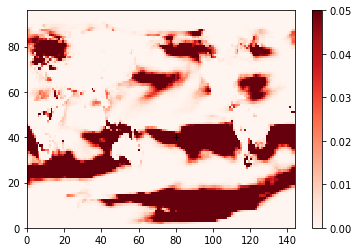

In [147]:
plt.pcolormesh(p, vmin=0, vmax=0.05, cmap=plt.cm.Reds)
plt.colorbar()
plt.plot([80],[40],'+k')

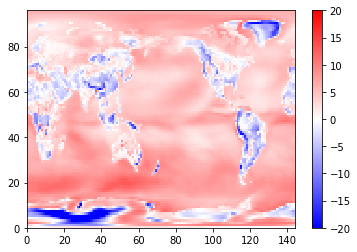

In [106]:
plt.pcolormesh(t, vmin=-20, vmax=20, cmap=plt.cm.bwr)
plt.colorbar()

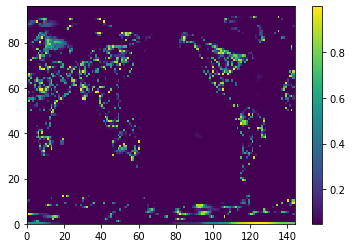

In [107]:
plt.pcolormesh(var_array_pvals[:,:,-1], vmin=0.05)
plt.colorbar()

# Make figures

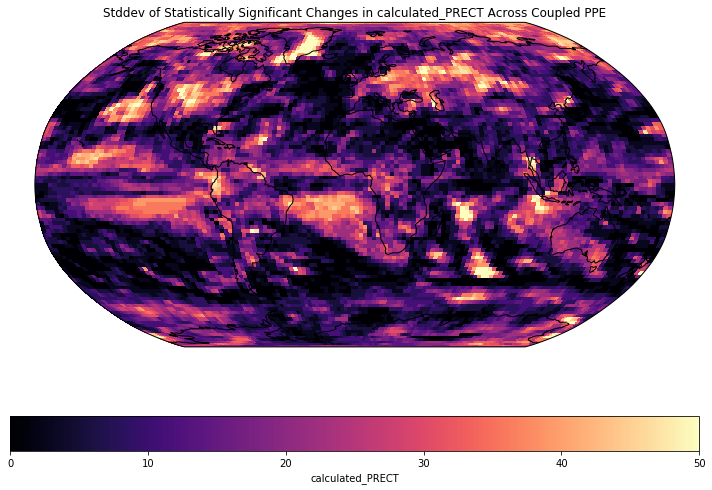

In [73]:
#mapdata=np.abs(var_array).quantile(0.75, dim='ensemble_key')#*86400*365*1000
mapdata=(var_array_pvals<0.05).sum(dim='ensemble_key')*100/np.size(var_array_pvals['ensemble_key'])

plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
               cyclic_data, 
               cmap=plt.cm.magma, vmin=0, vmax=50, ##vmin=0, vmax=1.5,
               transform=ccrs.PlateCarree())#, extend='both')
plt.title('Stddev of Statistically Significant Changes in '+
          var+
          ' Across Coupled PPE')
plt.colorbar(orientation='horizontal', label=var)
plt.savefig('figures/VariationMaps_'+var+'_'+season+'.png')
plt.tight_layout()

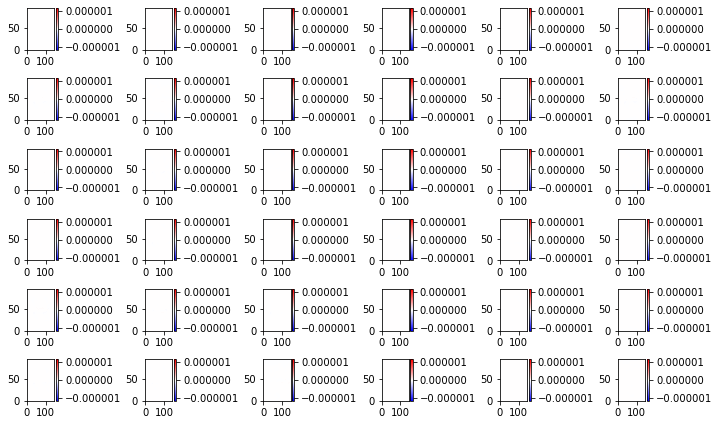

In [22]:
plt.figure(figsize=(10,6))
for i in np.arange(0,36):
    plt.subplot(6,6,i+1)
    plt.pcolormesh(var_array[:,:,i], vmax=0.1/86400, vmin=-0.1/86400, cmap=plt.cm.bwr)
    plt.colorbar()
plt.tight_layout()

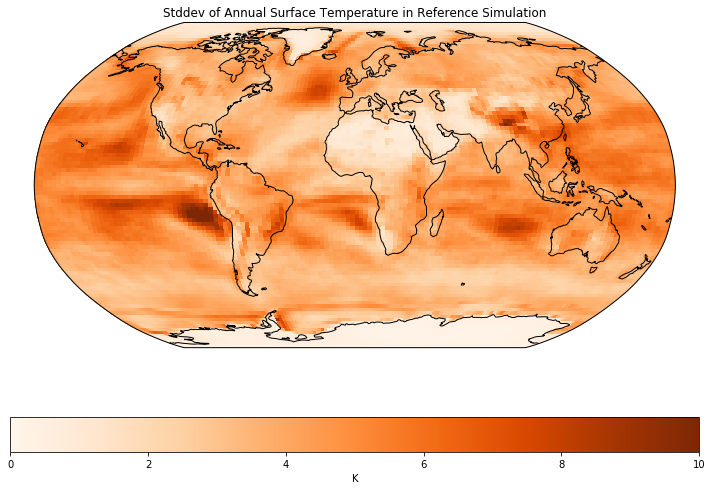

In [107]:
mapdata=ref_tseries.std(dim='year')#*86400*365*1000

plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, 
               cyclic_data, 
               cmap=plt.cm.Oranges, vmin=0, vmax=10,
               transform=ccrs.PlateCarree())
plt.title("Stddev of Annual Surface Temperature in Reference Simulation")
plt.colorbar(orientation='horizontal', label='K')
plt.tight_layout()

In [ ]:
mapdata=var_array.std(dim='ensemble_key')

plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, 
               cyclic_data, 
               cmap=plt.cm.Blues, vmin=0, vmax=1.1,
               transform=ccrs.PlateCarree())
plt.title("Stddev of Statistically Significant Changes in Surface Temperature Across Coupled PPE")
plt.colorbar(orientation='horizontal', label='K')
plt.tight_layout()

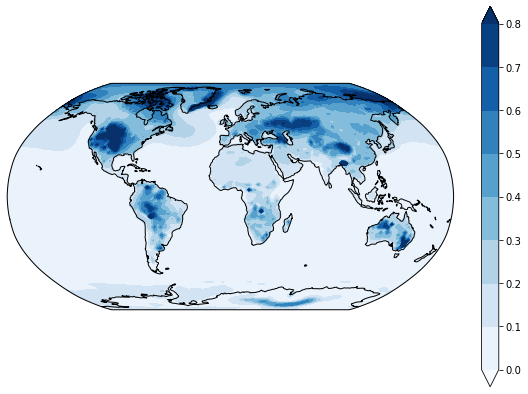

In [118]:
mapdata=var_array.var(dim='ensemble_key')

plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.contourf(cyclic_lons, mapdata.lat, 
               cyclic_data, 
               cmap=plt.cm.Blues, levels=np.arange(0,0.9,0.1),extend='both',
               transform=ccrs.PlateCarree())
plt.colorbar()

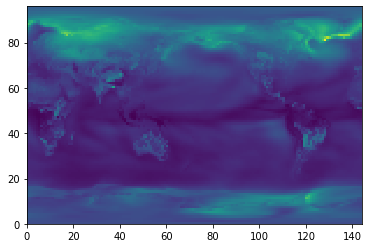

In [121]:
plt.pcolormesh(ref_tseries.std(dim='year'))